In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import torchvision.models as models


Bad key "text.kerning_factor" on line 4 in
/home/sachi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
train_path = "/home/sachi/Desktop/intern/archive/cityscapes_data/cityscapes_data/train/"
test_path = "/home/sachi/Desktop/intern/archive/cityscapes_data/cityscapes_data/val/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2975 500
/home/sachi/Desktop/intern/archive/cityscapes_data/cityscapes_data/train/53.jpg


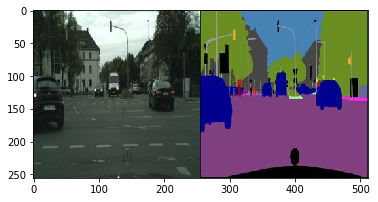

In [3]:
train_fns = os.listdir(train_path)
val_fns = os.listdir(test_path)
print(len(train_fns), len(val_fns))
sample_image_fp = os.path.join(train_path, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [14]:
color_array = np.array([(  0,  0,  0),( 81,  0, 81) ,(128, 64,128) , (244, 35,232),(250,170,160) ,(230,150,140),( 70, 70, 70),
(102,102,156), (190,153,153) ,(153,153,153) ,(250,170, 30),(220,220,  0),( 70,130,180),(220, 20, 60),( 0, 0,142),(107,142, 35)])


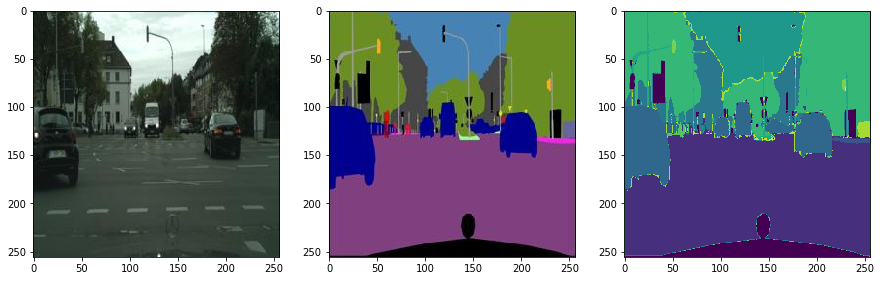

In [15]:
#num_items = 1000
#np.random.seed(7)
#color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)

num_classes = 16
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [12]:
label_class

array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5, 10, 10, ..., 10, 10, 10],
       [ 5, 10,  7, ..., 10, 10,  5],
       ...,
       [ 2,  9,  9, ...,  9,  9,  2],
       [ 2, 10, 10, ..., 10, 10,  5],
       [ 5,  5,  5, ...,  5,  2,  5]], dtype=int32)

In [6]:
class cityscape(Dataset):   
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(224, 224)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        #image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        cityscape = cv2.resize(cityscape ,(224,224))
        label = cv2.resize(label ,(224,224))
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [7]:
train_dataset = cityscape(train_path,label_model)
train_loader = DataLoader(train_dataset, batch_size=4,shuffle=False)

test_dataset = cityscape(test_path,label_model)
test_loader = DataLoader(test_dataset, batch_size=4,shuffle=False)

In [8]:
print(len(train_dataset), len(train_loader))

X, Y = iter(train_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])


In [9]:
def convblock(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        self.resnet = models.resnet18(pretrained = True)
        
        
        self.base_layers = list(self.resnet.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convblock(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convblock(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convblock(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convblock(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convblock(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convblock(256 + 512, 512, 3, 1)
        self.conv_up2 = convblock(128 + 512, 256, 3, 1)
        self.conv_up1 = convblock(64 + 256, 256, 3, 1)
        self.conv_up0 = convblock(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convblock(3, 64, 3, 1)
        self.conv_original_size1 = convblock(64, 64, 3, 1)
        self.conv_original_size2 = convblock(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, 10, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [10]:
model = UNet().to(device)

In [11]:
'''#base_params = list(map(id, model.resnet.parameters()))
conv_original0_param = list(map(id, model.conv_original_size0.parameters()))
conv_original1_param = list(map(id, model.conv_original_size1.parameters()))
rest_of_layer = filter(lambda p: id(p) not in base_params + conv_original0_param + conv_original1_param,
                     model.parameters())
params = [{'params': model.resnet.paramerters(), 'lr' : 0.00001},
          {'params': model.conv_original0_param.parameters(), 'lr': 0.00001},
          {'params': model.conv_original1_param.parameters(), 'lr': 0.00001},
          {'params': model.rest_of_layer.parameters() }]
'''

"#base_params = list(map(id, model.resnet.parameters()))\nconv_original0_param = list(map(id, model.conv_original_size0.parameters()))\nconv_original1_param = list(map(id, model.conv_original_size1.parameters()))\nrest_of_layer = filter(lambda p: id(p) not in base_params + conv_original0_param + conv_original1_param,\n                     model.parameters())\nparams = [{'params': model.resnet.paramerters(), 'lr' : 0.00001},\n          {'params': model.conv_original0_param.parameters(), 'lr': 0.00001},\n          {'params': model.conv_original1_param.parameters(), 'lr': 0.00001},\n          {'params': model.rest_of_layer.parameters() }]\n"

In [12]:
base_params = list(map(id, model.resnet.parameters()))
conv_original0_param = list(map(id, model.conv_original_size0.parameters()))
conv_original1_param = list(map(id, model.conv_original_size1.parameters()))
rest_of_layer = filter(lambda p: id(p) not in base_params + conv_original0_param + conv_original1_param,
                     model.parameters())
params = [{'params': model.resnet.parameters(), 'lr': 0.0001},
          {'params': model.conv_original_size0.parameters(), 'lr': 0.001},
          {'params': model.conv_original_size1.parameters(), 'lr': 0.001},
          {'params': rest_of_layer }]

In [13]:
critrian = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr=0.001)

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        image, label = data[0].to(device) , data[1].to(device)
        #torch.reshape(input,(4,3,32,32))
        optimizer.zero_grad()
        output = model(image)
        loss = critrian(output,label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0

[1,   100] loss: 1.471
[1,   200] loss: 1.005
[1,   300] loss: 0.848
[1,   400] loss: 0.778


In [ ]:
X, Y = next(iter(test_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(4, 3, figsize=(3*5, 4*5))

for i in range(4):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")